In [7]:
import tensorflow as tf
import os
import cv2
import imghdr


# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')


data_dir = 'manji' 
image_exts = ['jpeg','jpg', 'bmp', 'png']


data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256,256), batch_size=32) #defaulted 32 batch size
element_spec = data.element_spec

# Access the first batch from the dataset
first_batch = next(iter(data))

# Extract the first image from the batch
first_image = first_batch[0][0]
image_shape = first_image.shape
image_size = (first_image.shape[0], first_image.shape[1])


#Class 0 = dobre slike
# Class 1 = lose slike
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

print(image_size)



data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()



train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Found 6255 files belonging to 2 classes.
(256, 256)


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)


# Model definition
model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dropout(0.5))  # Add dropout layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer
model.add(BatchNormalization())  # Add batch normalization
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Learning rate scheduler
def scheduler(epoch, lr):
    return lr * 0.9  # You can adjust the multiplier as needed

lr_scheduler = LearningRateScheduler(scheduler)

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Training the model
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback, lr_scheduler, early_stopping, model_checkpoint])


In [4]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


print(pre.result(), re.result(), acc.result())

# Test on single pic

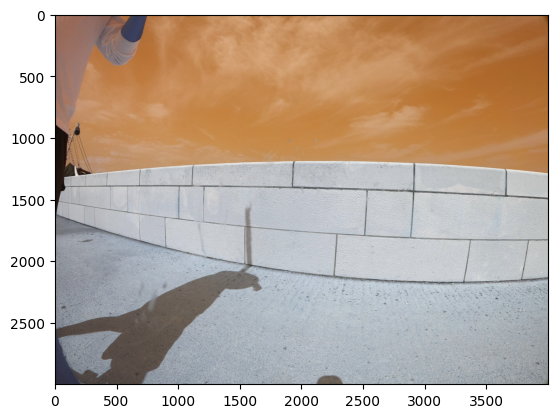

In [14]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('Cam_D_087901.jpg')
plt.imshow(img)
plt.show()

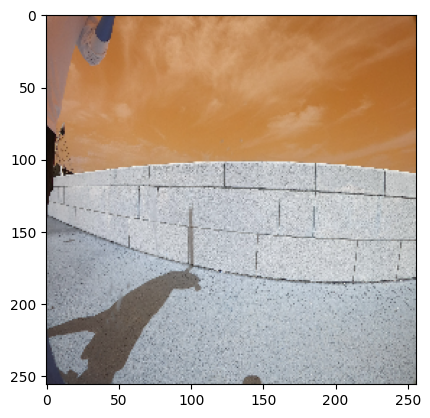

In [15]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [16]:
import numpy as np
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat[0][0]



1/1 [==============================] - 0s 26ms/step


0.9972584

In [17]:
if yhat[0][0]> 0.5: 
    print(f'Predicted class is Lose')
else:
    print(f'Predicted class is Dobra')

Predicted class is Lose


# save model

In [ ]:
# save model 
from tensorflow.keras.models import load_model
model.save(os.path.join('models','3000_losih_i_dobrih_1_projekt_model.h5'))


In [2]:
from tensorflow.keras.models import load_model
model = load_model('models/3000_losih_i_dobrih_1_projekt_model.h5')